## Testing iGraph for Adjacency Matrix, Degree Matrix & Graph Construction

### Imports

In [2]:
#import networkx as nx ## is good but somehow doesn't return proper adjacency matrix for the graph ????
import igraph as ig
import numpy as np 
## this fun baby 
from numba import jit 

### 1. Parameter Definition 

- Initial number of nodes 
- Create a random array: 
    - Size = (NODES x NODES)
    - Values = 0 to 1, showing an edge or not
- Remove the diagonal (this means no self-loops. for example Node 3 to Node 3)
- Convert np.array to np.matrix 

In [3]:
## 1. --- Initial number of nodes 
INITIAL_NODES = 4
## 2. --- To make things simpler, make it into a tuple
INITIAL_SIZE = (INITIAL_NODES, INITIAL_NODES)
## 3. ---  random adjacency arrays of shape: nodes x nodes
rand_adjarr = np.random.randint(low = 0,  
                              high = 2,
                              size = INITIAL_SIZE)
## 4. --- Remove the diagonal -- NO SELF-LOOPS
np.fill_diagonal(rand_adjarr, 0)

## 5. --- Convert to numpy matrix --> so we are working with matrix-matrix, and not array-matrix. Just in case! 
rand_adjm = np.matrix(rand_adjarr)

## 6. --- Take a look at the matrix 
print(rand_adjm)

[[0 0 1 0]
 [0 0 1 0]
 [1 1 0 1]
 [1 0 1 0]]


### 2. Methods to create graph from adjacency matrix 

- Method 1: 
    - Adjacency Matrix to bool (True/False) and then to a list

- Method 2: 
    - Pass Adjacency Matrix directly to iGraph 


In [4]:
## 1. --- Method 1: Adjm -> bool -> list 
g1 = ig.Graph.Adjacency(rand_adjm.astype(bool).tolist())
## 2. --- Get the degreees 
g1_d = g1.degree()
## 3. --- Method 2: Adjm -> graph 
g2 = ig.Graph.Adjacency(rand_adjm)
## 4. --- Get the degrees 
g2_d = g2.degree()
## 5. --- Look at them 
print(f"Method1 -> {g1_d}")
print(f"Method2 -> {g2_d}")
print(f"Are they the same?? -> {g1_d == g2_d}")

Method1 -> [3, 2, 6, 3]
Method2 -> [3, 2, 6, 3]
Are they the same?? -> True


### 3. Get the Degree Matrix from the Adjacency Matrix 

- Method 1: Colsum + Rowsum  

In [5]:
## 1. --- Rowsum, the sum of all the rows in a matrix, along axis 0.
rowsum = np.sum(rand_adjm, axis=0)
## 2. --- Colsum, sum of all the columns in a matrix along axis 1. 
colsum = np.sum(rand_adjm, axis=1).T # Transpose because it is a column vector and need a row vector
## 3. --- Sum them.  & convert to list so we dont have the matrix([x,x,x,x]) 
degrees = (rowsum + colsum).tolist()[0] ## get the 0th element because it is nested [[1,2,3,4]] --> [1,2,3,4]
# 4. --- Look at it 
print(f"Degrees from numpy operations -> {degrees}")
print(f"Degrees from Method 1         -> {g1_d}")
print(f"Degrees from Method 2         -> {g2_d}")
## 4. --- Compare it to the two methods before 
print(f"Method 1. Are they the same?  -> {g1_d == degrees}")
print(f"Method 2. Are they the same?  -> {g2_d == degrees}")


Degrees from numpy operations -> [3, 2, 6, 3]
Degrees from Method 1         -> [3, 2, 6, 3]
Degrees from Method 2         -> [3, 2, 6, 3]
Method 1. Are they the same?  -> True
Method 2. Are they the same?  -> True


In [6]:
## 1. -- Final Check! 
## THEY ARE THE SAME IM SO HAPPY OMG! :D :D :D
rand_adjm == np.matrix(g1.get_adjacency().data) ## Our Adjacency Matrix Vs. Adjacency Matrix from iGraph!! 

matrix([[ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True]])

### 4. Make a function and improve performance

In [7]:
## can we jit it??!?! 
## YES WE CAN 
"""
Elapsed (with compilation)  = 0.006689786911010742
Elapsed (after compilation) = 0.0001480579376220703 
4518x faster !!!!!
Como funciona esta mierda? 
1. Le agregas el "decorador" @jit --> esto es un Just In Time compiler, compila el Python a C 
2. se le agrega el nopython=True, asi corre el codigo compilado en C y no el python 
3. aumentamos velocidad con Parallel=True, para multiprocessing 
4. nogil=True, Libera el Global Interpreter Lock (que limita el acceso a los coros del procesador)
--- AHORA----
La primera vez que corres la funcion, va  ser lenta, pq se compila 
Despues es Speedy Fucking Gonzales.
"""
@jit(nopython=True,parallel=True,nogil=True) ## fucking fast man!
def get_degree_matrix(adjacency_matrix:np.matrix) -> np.matrix:
    """Returns degree matrix from adjacency matrix"""
    ## create an empty matrix to return the values 
    empty_like = np.zeros_like(adjacency_matrix)
    ## calculate the rowsum 
    rowsum = np.sum(adjacency_matrix, axis=0)
    ## calculate the colsum & transpose 
    colsum = np.sum(adjacency_matrix, axis=1).T
    ## sum them 
    degrees = rowsum + colsum 
    ## fill the empty matrix 
    np.fill_diagonal(empty_like, degrees)
    return empty_like

In [17]:
degrees = get_degree_matrix(rand_adjarr)
degrees

array([[3, 0, 0, 0],
       [0, 2, 0, 0],
       [0, 0, 6, 0],
       [0, 0, 0, 3]])

### Getting the new nodes to add

0. Get all degrees
1. Get the sum of all the degrees 
2. Calculate P(x) for each degree (degrees / ∑d)
3. Generate a random number uniform number from (0, 1)
4. Multiply the random number by the sum of degrees (Normalization)
5. get the bins 
6. which node to add 
7. attach the node and repeat steps 1-6

In [10]:
seed = np.random.seed(42)
## 0. -- Get all degrees -> remember we get a matrix, so we only get the diagonal
degrees = np.diag(get_degree_matrix(rand_adjm))
## 1. -- Sum of all degrees
sum_degrees = np.sum(degrees)
## 2. -- Probabilitie for each degree
degree_proba = degrees / sum_degrees
## 3. -- random uniform from 0 to sum(degree)
rand_val = np.random.uniform(0, 1) * sum_degrees
## 4. -- Get the bins
deg_bins = degrees.cumsum()
## insert a 0 at the beginning 
deg_bins = np.concatenate((deg_bins[:0], [0], deg_bins[0:]))
## 5. -- Identify which node to add it to 
add_node = np.digitize(rand_val, deg_bins)
## 6. -- Attach node (extending the matrix)

print(degrees)
print(sum_degrees)
print(degree_proba)
print(rand_val,'--')
print(deg_bins)
print(add_node)

[3 2 6 3]
14
[0.21428571 0.14285714 0.42857143 0.21428571]
5.243561663863074 --
[ 0  3  5 11 14]
3


In [19]:
rand_adjm

matrix([[0, 0, 1, 0],
        [0, 0, 1, 0],
        [1, 1, 0, 1],
        [1, 0, 1, 0]])

In [18]:
## lets say we wanted to build a graph that had 50 nodes 
FINAL_NODES = 50
## we'd need to create an empty graph 
final_empty = np.zeros(shape=(FINAL_NODES,FINAL_NODES))
## we put the current matrix into it 
## get the shape of the original one 
a, b = rand_adjm.shape
final_empty[:a,:b] = rand_adjm
#print(final_empty)
## the second node is index 1, not 2
## so index_node = add_node -1 
index_node = add_node - 1 
## locate the new node and add a connection 
## we keep the value of the original one
target = INITIAL_NODES
## thi is one is added
new_to_add = target + 1
## row x col
final_empty[target,index_node] = 1
final_empty[index_node, target] = 1
## sample one 
sample = final_empty[:new_to_add,:new_to_add]
sample

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 1., 0., 1., 1.],
       [1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

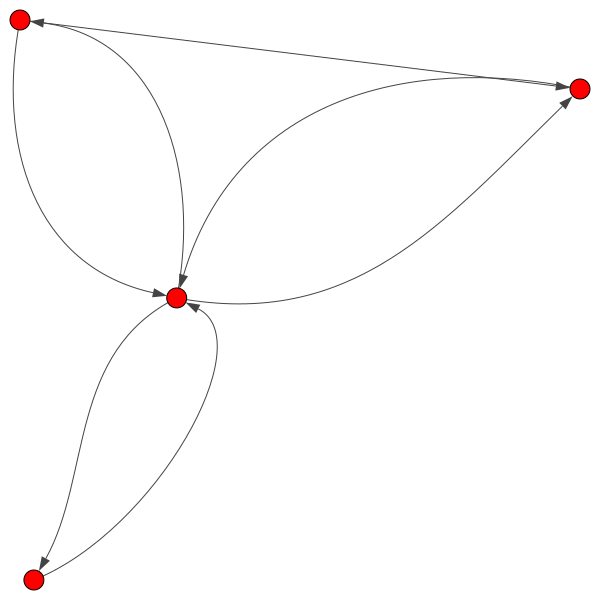

In [15]:
ig.plot(g1)

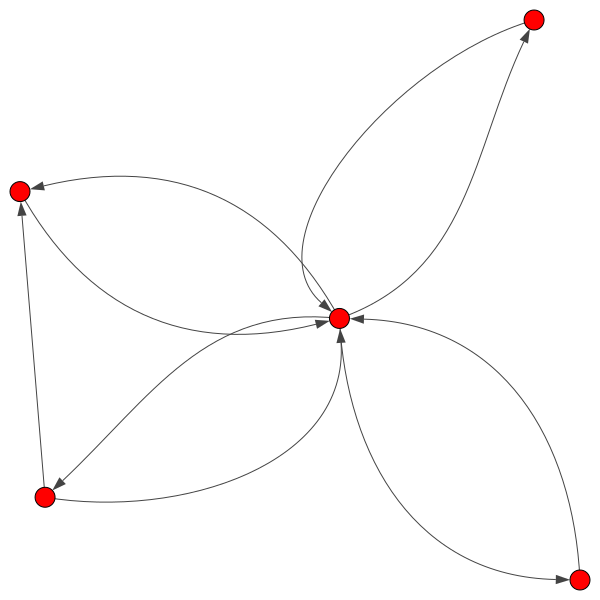

In [16]:
gg = ig.Graph.Adjacency(sample)
ig.plot(gg)